# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 32

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

# import packages
import tarfile
import os
import cv2 as cv
import skimage
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import filters
from scipy import ndimage
from skimage import morphology
import webcolors---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
# import packages
import tarfile
import os
import cv2 as cv
import skimage
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import filters
from scipy import ndimage
from skimage import morphology
import webcolors

In [2]:
#data_base_path = os.path.join(os.pardir, 'data')
data_base_path = os.path.join('/home/iapr', 'data')
data_folder = 'lab-01-data'
data_path = os.path.join(data_base_path, data_folder)
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [3]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames) 
images = skimage.io.concatenate_images(ic) # Height*Weight#RGB  480*640*[RGB]
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


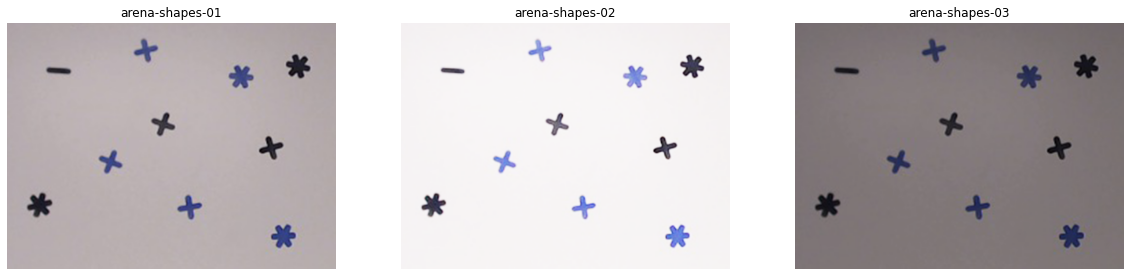

In [4]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(20, 20))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

#### 2.1.1 Histogram
An image is made up of pixels with different grey levels and the distribution of grey levels in an image is an important feature of that image. The histogram of an image depicts the distribution of greyscales in the image and provides a visual representation of how much of the image is occupied by each grey level.

To facilitate the task that follows, the histogram of the image is first plotted here.


In [5]:
# define a function for ploting multiple images
def plotMultipleImages(nrows, ncols, images, titles, type, cmap=False):
    if type=='typ_img':
        fig = plt.figure(figsize=(10,4))
        # fig.set_tight_layout(True)
        fig.subplots_adjust(hspace=0.4, wspace=0.3)
        for i in range(len(titles)):
            ax = fig.add_subplot(nrows, ncols, i+1)
            if cmap==False:                
                ax.imshow(images[i])
            else:
                ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')
    else:
        fig = plt.figure(figsize=(10,4))
        fig.subplots_adjust(hspace=0.4, wspace=0.3)
        for i in range(len(titles)):
            fig.add_subplot(nrows, ncols, i+1)
            if images[i].max() > 1.01:
                plt.hist(images[i].ravel(), 256, [0, 256])
            else:
                plt.hist(images[i].ravel(), 100, [0, 1]) 
            plt.title(titles[i])
            # ax = plt.gca()
            # ax.axes.xaxis.set_ticks([])
            # ax.axes.yaxis.set_ticks([])
    plt.show()


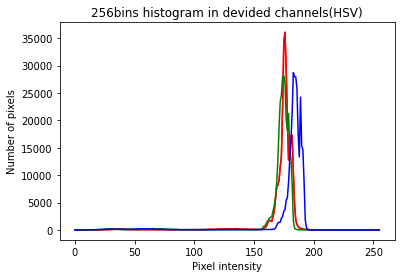

In [6]:
image=images[0][:,:,::-1]
HSV_img = cv.cvtColor(image,cv.COLOR_BGR2HSV)        
histr = cv.calcHist([image],[0],None,[256],[0,256])
plt.plot(histr,color = 'r')
color = ('r','g','b')
for i,col in enumerate(color):
    histr = cv.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('256bins histogram in devided channels(HSV)')
plt.show()

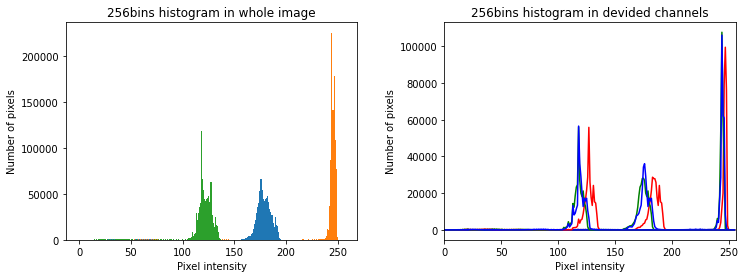

In [7]:
# plot the histogram of the images 
color = ('r','g','b')
# fig = plt.figure(figsize=(20,6))
fig, ax = plt.subplots(1,2,figsize=(12,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.subplot(1,2,1)
for im in images:
    plt.hist(im.ravel(), 256, [0, 256]) 
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('256bins histogram in whole image')
# plt.show()
plt.subplot(1,2,2)
i=0
for im in images:
    for i,col in enumerate(color):
        # histr = cv.calcHist([im],[i],None,[256],[0,255])
        histr = cv.calcHist([im],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
    plt.xlim([0,256])
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('256bins histogram in devided channels')
plt.show()



Each peak in the two subplots represents the distribution of pixels in an independent image data, where the second subplot shows the distribution of pixels in different channels in each image. 
It can be concluded that the RGB channels in the three pictures are relatively concentrated and have linear characteristics, but the peaks of the three pictures are different from each other, which also confirms the different lighting conditions of the three pictures. The next step is to perform histogram equalization and color transformation of space, i.e. to convert RGB to HSV.

### 2.2 Number of shapes of each color (5 pts)

#### 2.2.1 Colour model comparison

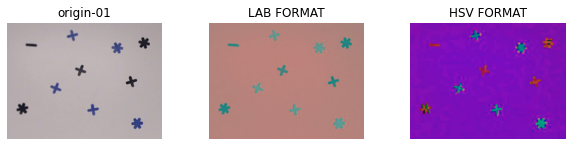

In [9]:
image = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-01.png')[:,:,::-1]
# image = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-01.png')
 
# converting the colourfull image into HSV format image
# using cv2.COLOR_BGR2HSV argument of
# the cvtColor() function of cv2
# in this :
# ist argument is the image matrix
# 2nd argument is the attribute
# image = cv2.GaussianBlur(image, (5, 5), 0)
LAB_img = cv.cvtColor(image,cv.COLOR_BGR2LAB)
HSV_img = cv.cvtColor(image,cv.COLOR_BGR2HSV)
imgs=[image,LAB_img,HSV_img]
titles=['origin-01','LAB FORMAT','HSV FORMAT' ]
plotMultipleImages(1, 3, imgs, titles, 'typ_img')

# # LAB_img = cv2.dilate(thresh, None, iterations=2)
# # HSV_img = cv2.erode(thresh, None, iterations=2)
# HSV_img = cv2.threshold(HSV_img, 10, 255, cv2.THRESH_BINARY)[1]
# LAB_img = cv2.cvtColor(HSV_img,cv2.COLOR_BGR2LAB)
# # plt.imshow(HSV_img)
# LAB_img = cv2.threshold(LAB_img, 200, 255, cv2.THRESH_BINARY)[1]
# plt.imshow(LAB_img)

#### 2.2.2 Intensity Equalization and Normalization
A comparison of the three images shows that they differ significantly in terms of luminance, and in order to make the algorithm more robust, a pixel normalisation strategy is to be used.

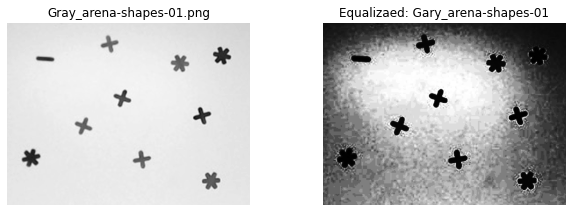

In [10]:
# Equalization
image = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-01.png')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
dst = cv.equalizeHist(gray)

# plot 
# plt.figure(figsize=(12,12))
# plt.subplot(121)
# plt.imshow(gray, cmap = 'gray')
# plt.subplot(122)
# plt.imshow(dst, cmap = 'gray')
# plt.show()
imgs = [gray, dst]
titles = ['Gray_arena-shapes-01.png', 'Equalizaed: Gary_arena-shapes-01']
plotMultipleImages(1, 2, imgs, titles,  type='typ_img', cmap='Ture')


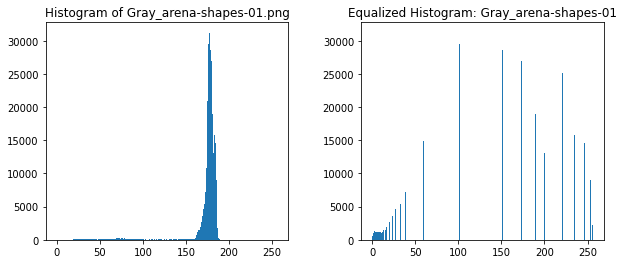

In [11]:
# plot histograms
imgs = [gray, dst]
titles = ['Histogram of Gray_arena-shapes-01.png', 'Equalized Histogram: Gray_arena-shapes-01']
plotMultipleImages(1, 2, imgs, titles,  type='typ_hst')

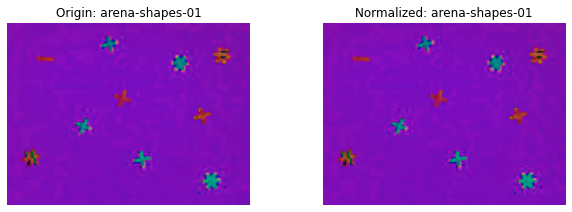

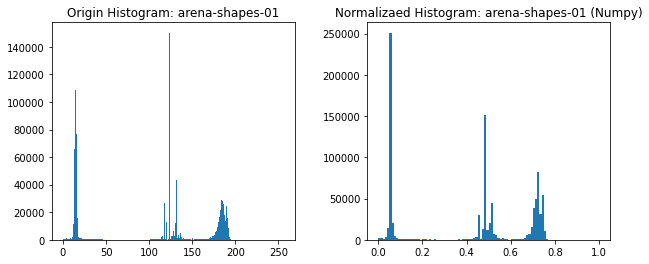

In [12]:
# 1.normalizaition using numpy
image = HSV_img
# image = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-01.png')
image_norm_numpy = (image - np.min(image)) / (np.max(image) - np.min(image))
imgs = [image, image_norm_numpy]
# plot images
titles = ['Origin: arena-shapes-01', 'Normalized: arena-shapes-01']
plotMultipleImages(1, 2, imgs, titles, type='typ_img')

# plot histograms
titles = ['Origin Histogram: arena-shapes-01', 'Normalizaed Histogram: arena-shapes-01 (Numpy)']
plotMultipleImages(1, 2, imgs, titles,  type='typ_hst')

# # 2.normalization using opencv
# h, w, ch = image.shape
# result = np.zeros((h, w, ch), dtype=np.uint8)
# cv.normalize(image, result, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)        
# images = [image, result]
# titles = ['Origin Histogram: arena-shapes-01', 'Normalizaed Histogram: arena-shapes-01 (OpenCV)']
# # plot histograms
# plotMultipleImages(1, 2, images, titles, 'typ_hst')

#### 2.2.4 Object detect

In [13]:
class Obj_Col_Analysis:

    def analysis(self, frame):
        self.col_rgb = []
        self.col_hsv = []
        self.vertex = []
        
        h, w, ch = frame.shape
        result = np.zeros((h, w, ch), dtype=np.uint8)

        # rgb->binary
        # Perform image greyscaling and threshold segmentation
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
        thresh =cv.Canny(binary, 50, 100)
        # plt.imshow()
        # plt.show()
        # Contour detect and visualization
        contours, hierarchy = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        obj_img = np.zeros((h, w, ch), dtype=np.uint8)
        cv.drawContours(obj_img, contours, -1, [255,255,255], thickness=-1)
        plt.figure(figsize=(3,3))
        plt.imshow(obj_img)
        plt.title('Contours of Objects Detected')
        plt.show()
        # Analysis of the detected contours in turn
        for cnt in range(len(contours)):
            # Contour approaching
            epsilon = 0.01 * cv.arcLength(contours[cnt], True)
            approx = cv.approxPolyDP(contours[cnt], epsilon, True)

            # Analyse the corners
            corners = len(approx)
            self.vertex.append(corners)
            
            # Obtaining the position of the centre of mass
            mm = cv.moments(contours[cnt])
            cx = int(mm['m10'] / mm['m00'])
            cy = int(mm['m01'] / mm['m00'])

            # Colour analysis
            img_rgb = frame[:,:,::-1]
            color = img_rgb[cy][cx]
            self.col_rgb.append(color)
            img_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            color = img_hsv[cy][cx]
            self.col_hsv.append(color)
            
            color_str = "("+ str(color[0]) + ", " + str(color[1]) + "," + str(color[2]) + ")"       
            
            print("Obj #%2d   Vertexs: %2d,  Color_HSV: %s " % ((cnt+1), corners, color_str))
            
        return contours, self.vertex, self.col_hsv, self.col_rgb

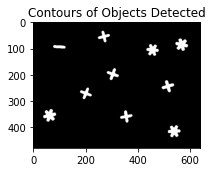

Obj # 1   Vertexs: 20,  Color_HSV: (117, 151,88) 
Obj # 2   Vertexs: 17,  Color_HSV: (117, 144,83) 
Obj # 3   Vertexs: 22,  Color_HSV: (120, 71,25) 
Obj # 4   Vertexs: 16,  Color_HSV: (115, 156,95) 
Obj # 5   Vertexs: 17,  Color_HSV: (124, 62,29) 
Obj # 6   Vertexs: 16,  Color_HSV: (135, 26,40) 
Obj # 7   Vertexs:  8,  Color_HSV: (132, 49,26) 
Obj # 8   Vertexs: 21,  Color_HSV: (116, 140,89) 
Obj # 9   Vertexs: 21,  Color_HSV: (120, 88,32) 
Obj #10   Vertexs: 17,  Color_HSV: (116, 132,81) 


In [14]:
src = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-03.png')
image_analyze = Obj_Col_Analysis()
contours, vertexs, col_hsv, col_rgb= image_analyze.analysis(src)

#### Analysis
1. The visualisation process, due to differences between the CV library and the PLT library in terms of the channels used to read and write the images, therefore the overall tone of the display is somewhat affected, but does not affect the analysis as a whole.
2. By vertex analysis, it can be concluded that there are a total of two distinct divisions within the margin of error, thus indicating that there are **three types of objects**.
3. Given the different luminance of the three images given in the dataset, the **V component** of HSV is filtered out to enhance the robustness of the algorithm to luminance. the **H component** has no obvious pattern, which leaves only the **S component**.

    Using the sample distribution analysis method, based on the colour data of ten object vertices (HSV format), where the distribution of Saturation(S) is roughly in two clusters, it can be roughly assumed that there are **two main types of object colours** in the image.  

#### 2.2.5 Color Classification

In [15]:
# Shape identification function 
def shape_identify(objs, corners, listOfKeys):  
    # print(corners)
    # print(objs)
    obj_num= objs
    corners= corners
    Keys = listOfKeys   
    
    # Sort objects from smallest to largest by number of vertices
    if corners < 10 :
        obj_num[Keys[0]] += 1
    if corners <= 17 & corners >= 10 :
        obj_num[Keys[1]] += 1
    if corners > 17:
        obj_num[Keys[2]] += 1
    return obj_num

# Color decode function (RGB_TO_TEXT)
def closest_colour(requested_colour):
    min_colours = {}
    # for key, name in webcolors.css3_hex_to_names.items():
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

In [16]:
# Color Homogenisation AND filter

hsv_mean = np.array((0,0,0))
hsv_1 = np.array((0,0,0))
hsv_2 = np.array((0,0,0))
rgb_1 = np.array((0,0,0))
rgb_2 = np.array((0,0,0))

obj = {'col_1':[],'col_2':[]}
col1_index = []
col2_index = []

# Calculate the mean value of ten colours
for col in col_hsv:
    hsv_mean += col
hsv_mean = hsv_mean/10

# Filter the two colours and the corresponding outlines separately
for i,col in enumerate(col_hsv):
    if col[1]>hsv_mean[1]:
        hsv_1 += col
        rgb_1 += col_rgb[i]
        col1_index.append(i)
        obj['col_1'].append(contours[i])
    else:
        hsv_2 += col
        rgb_2 += col_rgb[i]
        col2_index.append(i)            
        obj['col_2'].append(contours[i])

In [17]:
col_obj_1 = [rgb_1, col1_index]
col_obj_2 = [rgb_2, col2_index]

for i, c in enumerate([col_obj_1, col_obj_2 ]):
    obj_col = {'Object1': 0, 'Object2': 0, 'Object3': 0}
    requested_colour = c[0]
    _, closest_name = get_colour_name(requested_colour)
    for j in c[1]:
        obj_col=shape_identify(obj_col, vertexs[j], listOfKeys = list(obj_col.keys()))
    print ("Color: ",  closest_name.upper())
    # if i == 0:
    #     print('\ncolor1_hsv:', hsv_1/5)
    #     print('color1_rgb:', rgb_1/5)
    # else:
    #     print('color2_rgb:', rgb_2/5)    
    #     print('color2_hsv:', hsv_2/5)
    print(obj_col,'\n...............')

Color:  LIGHTCYAN
{'Object1': 0, 'Object2': 3, 'Object3': 2} 
...............
Color:  SLATEGRAY
{'Object1': 1, 'Object2': 2, 'Object3': 2} 
...............


#### Conclusion

* Color:  LIGHTCYAN
         {'Object1': 0, 'Object2': 3, 'Object3': 2} 
         

* Color:  SLATEGRAY
        {'Object1': 1, 'Object2': 2, 'Object3': 2} 

*NOTE: Objects are sorted from smallest to largest by number of vertices*

### 2.3 Total area (in pixels) of each color (5 pts)

**Some comments of the algorithm... (to be updated)**


Total area (in pixels) of color LIGHTCYAN is: 5158

Total area (in pixels) of color SLATEGRAY is: 5159


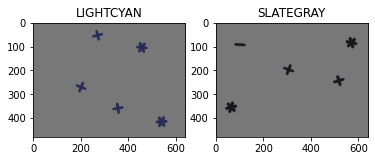

In [18]:
frame = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-01.png')
h, w, ch = frame.shape
titles = ['LIGHTCYAN', 'SLATEGRAY']
colors = [(37.6, 44.2, 87.2), (24.6, 23.6, 30.4)]
# Pixels Count and visualization
for i,cnt in enumerate([obj['col_1'], obj['col_2']]):
    obj_img = np.ones((h, w, ch), dtype=np.uint8)*120
    cv.drawContours(obj_img, cnt, -1, colors[i], thickness=-1)
    gray = cv.cvtColor(obj_img, cv.COLOR_BGR2GRAY)
    ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV| cv.THRESH_OTSU)
    values, counts = np.unique(binary, return_counts=True)
    print()
    print('Total area (in pixels) of color',titles[i], 'is:',counts[1] )
    
    plt.subplot(1,2,i+1)
    plt.title(titles[i])
    plt.imshow(obj_img)
plt.show()

#### Conclusion


* Total area (in pixels) of color LIGHTCYAN is: 5158

* Total area (in pixels) of color SLATEGRAY is: 5159

*Suprisingly identical.*